In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import h5py
import numpy as np
import json
import urllib.request
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from IPython.display import Image, display, clear_output
from sklearn.metrics import classification_report, confusion_matrix

%matplotlib inline
sns.set_style('whitegrid')

In [ ]:
from keras import optimizers
from keras import applications
from keras.applications.vgg16 import VGG16
from keras.models import Sequential, load_model, Model
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, Activation, Dropout, Flatten, Dense, Input
from keras.regularizers import l2, l1
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint, History
from keras import backend as K
from keras.utils.data_utils import get_file
from tensorflow.keras.utils import load_img

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import img_to_array

In [ ]:
def save_bottleneck_features():
    datagen = ImageDataGenerator(rescale=1./255)
    
    model = VGG16(include_top=False, weights='imagenet')
    
    generator = datagen.flow_from_directory(train_data_dir, target_size=(img_width, img_height), batch_size=batch_size, class_mode=None, shuffle=False)
    bottleneck_features_train = model.predict(generator, nb_train_samples // batch_size)
    np.save(location+'/bottleneck_features_train.npy', bottleneck_features_train)
    
    generator = datagen.flow_from_directory(validation_data_dir, target_size=(img_width, img_height), batch_size=batch_size, class_mode=None, shuffle=False)
    bottleneck_features_validation = model.predict(generator, nb_validation_samples // batch_size)
    np.save(location+'/bottleneck_features_validation.npy', bottleneck_features_validation)

In [ ]:
def print_best_model_results(model_hist):
    best_epoch = np.argmax(model_hist['val_accuracy'])
    print('epoch:', best_epoch+1, \
    ', val_accuracy:', model_hist['val_accuracy'][best_epoch], \
    ', val_loss:', model_hist['val_loss'][best_epoch])

In [ ]:
def plot_metrics(hist, stop=50):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
                            
    axes = axes.flatten()

    axes[0].plot(range(stop), hist['accuracy'], label='Training', color='#FF533D')
    axes[0].plot(range(stop), hist['val_accuracy'], label='Validation', color='#03507E')
    axes[0].set_title('Accuracy')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(loc='lower right')
                             
    axes[1].plot(range(stop), hist['loss'], label='Training', color='#FF533D')
    axes[1].plot(range(stop), hist['val_loss'], label='Validation', color='#03507E')
    axes[1].set_title('Loss')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(loc='upper right')
                             
    plt.tight_layout();
    
    print("Best Model:") 
    print_best_model_results(hist)

In [ ]:
def plot_acc_metrics(hist1, hist2, stop=50):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(4.25,6))
                            
    axes = axes.flatten()
    
    axes[0].plot(range(stop), hist1['accuracy'], label='Training', color='#FF533D')
    axes[0].plot(range(stop), hist1['val_accuracy'], label='Validation', color='#03507E')
    axes[0].set_title('Training')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(loc='lower right')
                             
    axes[1].plot(range(stop), hist2['accuracy'], label='Training', color='#FF533D')
    axes[1].plot(range(stop), hist2['val_accuracy'], label='Validation', color='#03507E')
    axes[1].set_title('Fine-tuning')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(loc='lower right')
                             
    plt.tight_layout();

In [ ]:
def train_categorical_model():
    train_data = np.load(location+'/bottleneck_features_train.npy')
    train_labels = np.array([0]*(419) + [1]*(288) + [2]*(272))
    train_labels = to_categorical(train_labels)
    
    validation_data = np.load(location+'/bottleneck_features_validation.npy')
    validation_labels = np.array([0]*(73) + [1]*(50) + [2]*(48))
    validation_labels = to_categorical(validation_labels)
    
    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))
    
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    
    checkpoint = ModelCheckpoint(top_model_weights_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True,mode='auto')
    
    fit = model.fit(train_data, train_labels, epochs=epochs, batch_size=batch_size, validation_data=(validation_data,validation_labels), callbacks=[checkpoint])
        
    with open(location+'/top_history.txt', 'w') as f:
        json.dump(fit.history, f)
    
    return model,fit.history

In [ ]:
def finetune_categorical_model():
    input_tensor = Input(shape=(256,256,3))
    base_model = VGG16(weights='imagenet',include_top= False,input_tensor=input_tensor)
    print("Model loaded.")
    top_model = Sequential()
    top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
    top_model.add(Dense(256, activation='relu'))
    top_model.add(Dropout(0.5))
    top_model.add(Dense(3, activation='softmax'))
    
    top_model.load_weights(top_model_weights_path)
    
    model = Model(inputs=base_model.input, outputs=top_model(base_model.output))
    
    for layer in model.layers[:25]:
        layer.trainable = False
    
    model.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(lr=0.00001, momentum=0.9), metrics=['accuracy'])
    
    train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
    
    test_datagen = ImageDataGenerator(rescale=1./255)
    
    train_generator = train_datagen.flow_from_directory(train_data_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical')
    
    validation_generator = test_datagen.flow_from_directory(validation_data_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical')
    
    checkpoint = ModelCheckpoint(fine_tuned_model_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')
    
    fit = model.fit_generator(train_generator, steps_per_epoch=nb_train_samples//batch_size, epochs=epochs, validation_data=validation_generator, validation_steps=nb_validation_samples//batch_size, verbose=1, callbacks=[checkpoint])
    
    with open(location+'/ft_history.txt', 'w') as f:
        json.dump(fit.history, f)
        
    return model, fit.history

In [ ]:
def evaluate_categorical_model(model, directory, labels):
    datagen = ImageDataGenerator(rescale=1./255)
    
    generator = datagen.flow_from_directory(directory, target_size=(img_height,img_width), batch_size=batch_size, class_mode='categorical', shuffle=False)
    
    predictions = model.predict_generator(generator, len(labels))
    
    pred_labels = [0 if i<0.5 else 1 for i in predictions]
    
    print('')
    print(classification_report(validation_labels, pred_labels))
    print('')
    cm = confusion_matrix(validation_labels, pred_labels)
    return cm

In [ ]:
#Input Image Details

In [ ]:
location = '/content/drive/MyDrive/DS_Project/Dataset/car-damage-dataset/data2a'
top_model_weights_path = location+'/top_model_weights.h5'
fine_tuned_model_path = location+'/ft_model.h5'

train_data_dir = location+'/training'
validation_data_dir = location+'/validation'
train_samples = [len(os.listdir(train_data_dir+'/'+i)) for i in sorted(os.listdir(train_data_dir))]
nb_train_samples = 979
validation_samples = [len(os.listdir(validation_data_dir+'/'+i)) for i in sorted(os.listdir(validation_data_dir))]
nb_validation_samples = 171

img_width, img_height = 256,256
#epochs = 50
epochs = 1
batch_size = 16

In [ ]:
save_bottleneck_features()

Found 979 images belonging to 3 classes.
62/62 [==============================] - 688s 11s/step
Found 171 images belonging to 3 classes.
11/11 [==============================] - 121s 11s/step


In [ ]:
d3_model, d3_history = train_categorical_model()

Epoch 1/50
62/62 [==============================] - ETA: 0s - loss: 4.7583 - accuracy: 0.3994
Epoch 1: val_accuracy improved from -inf to 0.49708, saving model to /content/drive/MyDrive/DS_Project/Dataset/car-damage-dataset/data2a/top_model_weights.h5
62/62 [==============================] - 6s 83ms/step - loss: 4.7583 - accuracy: 0.3994 - val_loss: 0.9841 - val_accuracy: 0.4971
Epoch 2/50
62/62 [==============================] - ETA: 0s - loss: 1.3606 - accuracy: 0.4821
Epoch 2: val_accuracy did not improve from 0.49708
62/62 [==============================] - 5s 79ms/step - loss: 1.3606 - accuracy: 0.4821 - val_loss: 1.1202 - val_accuracy: 0.4912
Epoch 3/50
62/62 [==============================] - ETA: 0s - loss: 1.0647 - accuracy: 0.5465
Epoch 3: val_accuracy improved from 0.49708 to 0.62573, saving model to /content/drive/MyDrive/DS_Project/Dataset/car-damage-dataset/data2a/top_model_weights.h5
62/62 [==============================] - 6s 89ms/step - loss: 1.0647 - accuracy: 0.5465 

Best Model:
epoch: 14 , val_accuracy: 0.7543859481811523 , val_loss: 0.8798369765281677


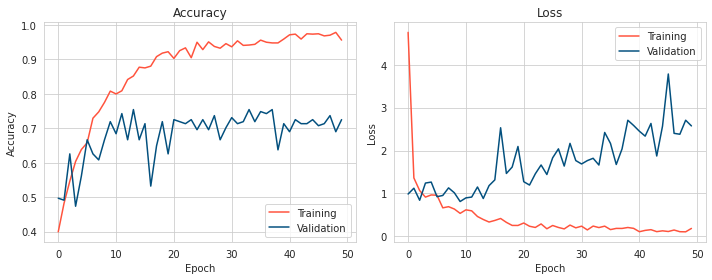

In [ ]:
plot_metrics(d3_history)

In [ ]:
ft_model, ft_history = finetune_categorical_model()

Model loaded.
Found 979 images belonging to 3 classes.
Found 171 images belonging to 3 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


61/61 [==============================] - ETA: 0s - loss: 0.6634 - accuracy: 0.7778 
Epoch 1: val_accuracy improved from -inf to 0.75000, saving model to /content/drive/MyDrive/DS_Project/Dataset/car-damage-dataset/data2a/ft_model.h5
61/61 [==============================] - 800s 13s/step - loss: 0.6634 - accuracy: 0.7778 - val_loss: 0.8373 - val_accuracy: 0.7500


In [ ]:
ft_model = load_model(location + '/ft_model.h5')

In [ ]:
validation_labels = np.array([0] * validation_samples[0] + 
                             [1] * validation_samples[1] +
                             [2] * validation_samples[2])

In [ ]:
#cm = evaluate_categorical_model(ft_model, validation_data_dir, validation_labels)

In [ ]:
def pipe3(image_path, model):
    urllib.request.urlretrieve(image_path, 'save.jpg')
    img = load_img('save.jpg', target_size=(256,256))
    x = img_to_array(img)
    x = x.reshape((1,)+x.shape)/255
    pred = model.predict(x)
    pred_labels = np.argmax(pred, axis=1)
    d = {0:'Front', 1:'Rear', 2:'Side'}
    for key in d.keys():
        if pred_labels[0] == key:
            print("Validating location of damage....Result:",d[key])
    print("Severity assessment complete.")

In [ ]:
pipe3('https://c8.alamy.com/comp/K8P5B1/damaged-car-left-at-side-of-city-road-after-traffic-accident-K8P5B1.jpg', ft_model)

1/1 [==============================] - 1s 1s/step
Validating location of damage....Result: Side
Severity assessment complete.
